# Fatima Fellowship Quick Coding Challenge (Pick 1)

Thank you for applying to the Fatima Fellowship. To help us select the Fellows and assess your ability to do machine learning research, we are asking that you complete a short coding challenge. Please pick **1 of these 5** coding challenges, whichever is most aligned with your interests. 

**Due date: 1 week**

**How to submit**: Please make a copy of this colab notebook, add your code and results, and submit your colab notebook to the submission link below. If you have never used a colab notebook, [check out this video](https://www.youtube.com/watch?v=i-HnvsehuSw).

**Submission link**: https://airtable.com/shrXy3QKSsO2yALd3

# 1. Deep Learning for Vision

**Upside down detector**: Train a model to detect if images are upside down

* Pick a dataset of natural images (we suggest looking at datasets on the [Hugging Face Hub](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads))
* Synthetically turn some of images upside down. Create a training and test set.
* Build a neural network (using Tensorflow, PyTorch, or any framework you like)
* Train it to classify image orientation until a reasonable accuracy is reached
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* Look at some of the images that were classified incorrectly. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

**Submission instructions**: Please write your code below and include some examples of images that were classified

# Upside down detector: Train a model to detect if images are upside down
* Pick a dataset of natural images \
Pick a dataset of natural images (we suggest looking at datasets on the Hugging Face Hub) \
We chose a fine-grained images dataset of faces \
description:

My model is an inverted image detector and can help detect if images are inverted with 99% accuracy. \
I used a dataset containing people with and without masks. I trained my model on ~ 300 images of people without masks and tested it on ~ 60 of the same images distribution: \
author = {Prasoon Kottarathil}, \
title = {Face Mask Lite Dataset}, \
year = {2020}, \
publisher = {kaggle}, \
journal = {Kaggle Data}, \
how published = {\url{https://www.kaggle.com/prasoonkottarathil/face-mask-lite-dataset}} \


All Images in this dataset are Generated Using Style GAN-2, \
10,000 HD images in  each Folder With mask and without mask 


* Synthetically turn some of images upside down. Create a training and test set.
* Build a neural network (using Tensorflow, PyTorch, or any framework you like)
* Train it to classify image orientation until a reasonable accuracy is reached
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.

link: https://huggingface.co/DIANKHA/upside-down/tree/main

Synthetically turn some of images upside down. Create a training and test set.

In [2]:
import os
def makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)

makedir('./without_mask')

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

#Imports
import os
import sys
from glob import glob
import torch
import torchvision

import numpy    as np
import datetime as dt


import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot   as plt
import cv2

from PIL               import Image
from torch.utils.data  import Dataset
from torch.autograd    import Variable
from torch.optim       import lr_scheduler

from torch.utils.data  import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision       import transforms, datasets, models
from os                import listdir, makedirs, getcwd, remove
from os.path           import isfile, join, abspath, exists, isdir, expanduser
from torchvision.transforms.functional import vflip
from PIL import Image
from torch.utils.data import random_split
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
np.random.seed(42)


%matplotlib inline


data_path = "./without_mask"
images = glob("./without_mask/*.png", recursive=True)


In [10]:
import shutil
!rm -rf ./train_data
!rm -rf ./test_data
makedir('./train_data')
makedir('./test_data')
split = int(np.floor(len(images) * .8))
np.random.seed(22)
N = len(images)
K = split 

dst_dir = 'train_data'
for pngfile in images[:split]:
    shutil.copy(pngfile, dst_dir)
dst_dir = 'test_data'
for pngfile in images[split:]:
    shutil.copy(pngfile, dst_dir)

In [11]:

# Transformations for both the training and testing data
mean=[0.5894, 0.4595, 0.3966]
std=[0.2404, 0.2020, 0.1959]

# Do data transforms here, Try many others

train_transforms = transforms.Compose([transforms.Resize(500),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([ transforms.Resize(500),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std)])

In [12]:
class Dataset(Dataset):
    def __init__(self, path, transform=None):
        self.file_list = glob(path+"*.png", recursive=True)
        print(self.file_list)
        self.transform = transform

        files = []
        split = int(np.floor(len(self.file_list) * .5))

        N = len(self.file_list)
        K = split # K zeros, N-K ones
        indices = np.array([0] * K + [1] * (N-K))
        np.random.shuffle(indices)
        print(indices)

        final_pth = path
        for idx,img_pth in enumerate(self.file_list):
          if indices[idx]:
            img = Image.open(img_pth)
            img = vflip(img)
            img_name = img_pth.split('/')[-1]
            img.save(final_pth+img_name, format="png")
            files.append([indices[idx],final_pth+img_name])
          else:
            img = Image.open(img_pth)
            img_name = img_pth.split('/')[-1]
            img.save(final_pth+img_name, format="png")
            files.append([indices[idx],final_pth+img_name])
        self.file_list = files
        print(self.file_list)
        files = None


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][1]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
            
        return im.view(3, 500, 500), classCategory



In [13]:
train_data = Dataset('./train_data/', transform=train_transforms)

['./train_data/seed9749.png', './train_data/seed9997.png', './train_data/seed9770.png', './train_data/seed6163.png', './train_data/seed9758.png', './train_data/seed6108.png', './train_data/seed9992.png', './train_data/seed6206.png', './train_data/seed9846.png', './train_data/seed9811.png', './train_data/seed6150.png', './train_data/seed9766.png', './train_data/seed9694.png', './train_data/seed6135.png', './train_data/seed6153.png', './train_data/seed6180.png', './train_data/seed9716.png', './train_data/seed6139.png', './train_data/seed9993.png', './train_data/seed9793.png', './train_data/seed9683.png', './train_data/seed9768.png', './train_data/seed9822.png', './train_data/seed9861.png', './train_data/seed9808.png', './train_data/seed6190.png', './train_data/seed9851.png', './train_data/seed6172.png', './train_data/seed6173.png', './train_data/seed9734.png', './train_data/seed9877.png', './train_data/seed9814.png', './train_data/seed6118.png', './train_data/seed9733.png', './train_data

In [14]:
test_data = Dataset('./test_data/', transform=test_transforms)

['./test_data/seed6125.png', './test_data/seed6130.png', './test_data/seed6124.png', './test_data/seed6161.png', './test_data/seed9848.png', './test_data/seed9752.png', './test_data/seed9829.png', './test_data/seed6160.png', './test_data/seed9799.png', './test_data/seed6184.png', './test_data/seed6169.png', './test_data/seed9976.png', './test_data/seed6140.png', './test_data/seed9804.png', './test_data/seed9771.png', './test_data/seed6138.png', './test_data/seed6143.png', './test_data/seed6123.png', './test_data/seed9736.png', './test_data/seed9982.png', './test_data/seed9820.png', './test_data/seed6177.png', './test_data/seed9849.png', './test_data/seed9729.png', './test_data/seed9795.png', './test_data/seed9873.png', './test_data/seed9821.png', './test_data/seed6113.png', './test_data/seed6170.png', './test_data/seed9700.png', './test_data/seed9838.png', './test_data/seed9684.png', './test_data/seed9871.png', './test_data/seed6188.png', './test_data/seed6154.png', './test_data/seed61

In [15]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)


# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:


# Define Models 

# Define Models 

class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 2, padding = 2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        #Block 2
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 2, padding = 2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        #Block 3
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 2, padding = 2)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        #Block 4
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 2, padding = 2)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        #Block 5
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 2, padding = 2)
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=2)

        # last fully-connected layer
        self.fc = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(.1)


    def forward(self, input):

        x = self.maxpool1(self.relu1(self.conv1(input)))
        x = self.dropout(x)
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.dropout(x)
        x = self.maxpool3(self.relu3(self.conv3(x)))
        x = self.dropout(x)
        x = self.maxpool4(self.relu4(self.conv4(x)))
        x = self.dropout(x)
        x = self.maxpool5(self.relu5(self.conv5(x)))
        x = self.dropout(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

 

In [ ]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model.""" 
    
    # Make sure model is in training mode.
    model.train()
    
    # Move model to the device (CPU or GPU).
    model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None

    print('----- Training Loop -----')
    # Loop over epochs.
    for epoch in range(num_epochs):
        
      # Loop over data.
      for batch_idx, (features, target) in enumerate(data_loader):
            
          # Forward pass.
        output = model(features.to(device))
        output = output.squeeze()
        target = target.float()
        loss = criterion(output.to(device), target.to(device))

          # Backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      # NOTE: It is important to call .item() on the loss before summing.
        if ema_loss is None:
            ema_loss = loss.item()
        else:
            ema_loss += (loss.item() - ema_loss) * 0.01 

      # Print out progress the end of epoch.
      print('Epoch: {} \tLoss: {:.6f}'.format(epoch, ema_loss))
  

In [19]:
def test(model, data_loader):
    """Measures the accuracy of a model on a data set.""" 
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    print('----- Model Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
        
        # Loop over test data.
        for features, target in data_loader:
          
            # Forward pass.
            output = model(features.to(device))
            
            # Get the label corresponding to the highest predicted probability.
            # pred = output.argmax(dim=1, keepdim=True)
            pred = torch.where(output>0.5,torch.ones(output.shape),torch.zeros(output.shape))
            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100. * correct / len(data_loader.dataset)
    print(f'Test accuracy: {correct} / {len(data_loader.dataset)} ({percent:.0f}%)')
    torch.save(model.state_dict(), 'model.ckpt')
    return percent

In [ ]:
num_epochs = 10
model = Classifier(1)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

train(model, criterion, train_loader, optimizer, num_epochs=num_epochs)

test(model, test_loader)

----- Training Loop -----
Epoch: 0 	Loss: 0.730098
Epoch: 1 	Loss: 0.726100
Epoch: 2 	Loss: 0.720697
Epoch: 3 	Loss: 0.701529
Epoch: 4 	Loss: 0.672204
Epoch: 5 	Loss: 0.630846
Epoch: 6 	Loss: 0.589794
Epoch: 7 	Loss: 0.556498
Epoch: 8 	Loss: 0.519711
Epoch: 9 	Loss: 0.498741
----- Model Evaluation -----
Test accuracy: 53 / 53 (100%)


100.0

In [ ]:
test(model, train_loader)

----- Model Evaluation -----
Test accuracy: 211 / 212 (100%)


99.52830188679245

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified images. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

In [17]:
model1 = Classifier(1)
model1.load_state_dict(torch.load('./model.ckpt'))
model1.eval()  # make sure the model is in evaluation mode
classes = ['no_flip','flip']

In [20]:
test(model1, train_loader)
test(model1, test_loader)

----- Model Evaluation -----
Test accuracy: 243 / 244 (100%)
----- Model Evaluation -----
Test accuracy: 61 / 61 (100%)


100.0

In [21]:
import random
from IPython import display

In [22]:
def random_predictions(data):
  for i in random.sample(range(len(data)),3):
      tensor,target = data[i]

      if device == "cuda":
          tensor = tensor.cuda()

      prediction = model1(tensor.unsqueeze(0)).item()
      if prediction>.5:
        prediction = 1
      else:
        prediction = 0
      print(
          "Img %d. Excpected class %s, but predicted class %s."
          % (
              i,
              classes[target],
              classes[prediction],
          )
      )
      img = Image.open(data.file_list[i][1])
      img = transforms.Resize(224)(img)
      display.display(img)

Img 1. Excpected class no_flip, but predicted class no_flip.


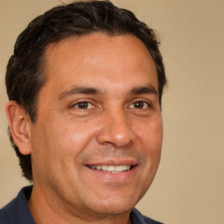

Img 24. Excpected class flip, but predicted class flip.


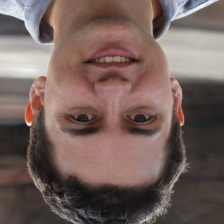

Img 23. Excpected class no_flip, but predicted class no_flip.


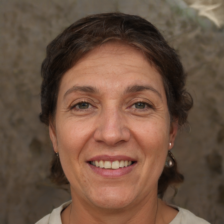

In [23]:
random_predictions(test_data)

In [26]:
def false_predictions(data):
  for i in range(len(data)):
      tensor, target = data[i]

      if device == "cuda":
          tensor = tensor.cuda()

      prediction = model1(tensor.unsqueeze(0)).item()
      if prediction>.5:
        prediction = 1
      else:
        prediction = 0
      
      if prediction != target:
          print(
              "Img id=%d. Excpected class %s, but predicted class %s."
              % (
                  i,
                  classes[target],
                  classes[prediction],
              )
          )
          img = Image.open(data.file_list[i][1])
          img = transforms.Resize(224)(img)
          display.display(img)



* Include some examples of poorly ranked images. Please explain what you could do to improve the performance of your model on these images.
We do not have enough information to comment on this misclassified image in the dataset.
This model was trained on a small dataset of ~300 images and tested on ~60 HD images generated with a GAN.
This dataset has the same distribution and is assumed to be not representive of the wide diversity of images in the real world.
We hope that our model can be useful in the context of creating a profile on a dating site or social network.
Our model could be improved by increasing the size and diversity of the training dataset. 

Img id=234. Excpected class flip, but predicted class no_flip.


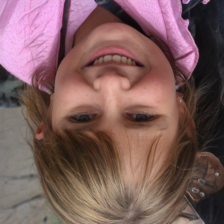

In [27]:
false_predictions(train_data)

In [48]:
addition_data = Dataset('./subset_without_mask/', transform=train_transforms)

['./subset_without_mask/seed9749.png', './subset_without_mask/seed9997.png', './subset_without_mask/seed9770.png', './subset_without_mask/seed9959.png', './subset_without_mask/seed9758.png', './subset_without_mask/seed9992.png', './subset_without_mask/seed9846.png', './subset_without_mask/seed9925.png', './subset_without_mask/seed9711.png', './subset_without_mask/seed9936.png', './subset_without_mask/seed9811.png', './subset_without_mask/seed9766.png', './subset_without_mask/seed9694.png', './subset_without_mask/seed9708.png', './subset_without_mask/seed9716.png', './subset_without_mask/seed9993.png', './subset_without_mask/seed9793.png', './subset_without_mask/seed9683.png', './subset_without_mask/seed9704.png', './subset_without_mask/seed9967.png', './subset_without_mask/seed9884.png', './subset_without_mask/seed9768.png', './subset_without_mask/seed9822.png', './subset_without_mask/seed9709.png', './subset_without_mask/seed9861.png', './subset_without_mask/seed9808.png', './subset_w

Img id=227. Excpected class flip, but predicted class no_flip.


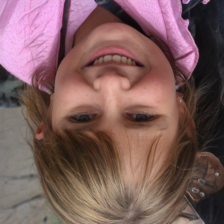

In [49]:
false_predictions(addition_data)